In [4]:
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

MASTER_FILE = os.path.join( '..', 'data', 'training_set.csv' )
DATA_DIR = os.path.join( '..', 'data', 'train' )
RESULTS_DIR = os.path.join( 'results' )

## PARAMS
IMAGE_SIZE = 256

## 01. Data Management:

Load the master file with the information per patient:


In [5]:
master_data = pd.read_csv( MASTER_FILE )[ ['file', 'label', 'patient_id'] ]
master_data = master_data.groupby('patient_id').agg({'file': list, 'label': lambda x: np.unique(x)[0] })
master_data = master_data.to_dict(orient='index')
print("Number of patients:", len(master_data) )

Number of patients: 9668


Write a custom pipeline to load data:

In [6]:
CLASS_NAMES = np.array( ['N', 'P', 'T'] )
autotune = tf.data.AUTOTUNE

def get_data_from_ids( split_ids ):
    """ Get master files for a given set of ids """
    split_data = []
    for split_id in split_ids:
        for file_id in master_data[split_id]['file']:
            file_path = os.path.join( DATA_DIR, file_id )
            split_data.append( f"{master_data[split_id]['label']}-{file_path}" )
    return split_data

def load_image( image_path, img_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """ Loads a random image for the patient"""
    img = tf.io.read_file( image_path )
    img = tf.io.decode_image( img, channels=3, expand_animations=False )
    img = tf.image.resize( img, img_size )
    return img

def preprocess_patient_path( patient_data ):
    ''' Load patient image and patient label'''
    parts = tf.strings.split( patient_data, '-')
    
    # get label
    one_hot = parts[0] == CLASS_NAMES
    patient_label = tf.cast(one_hot, dtype=tf.int8)

    # get image
    patient_image = load_image( parts[1] )
    return patient_image, patient_label

def define_dataset(train_ids, valid_ids):
    """ Init and preprocess the datasets """

    # get master data into the train and valid data
    train_data = get_data_from_ids(train_ids)
    val_data = get_data_from_ids(valid_ids)

    # load the labels file
    train_ds = tf.data.Dataset.from_tensor_slices( train_data )
    val_ds = tf.data.Dataset.from_tensor_slices( val_data )

    # add shuffling
    train_ds = train_ds.shuffle(buffer_size=len(train_data), reshuffle_each_iteration=True )
    val_ds = val_ds.shuffle(buffer_size=len(val_data), reshuffle_each_iteration=True )

    # add the patient data to the datasets
    train_ds = train_ds.map( preprocess_patient_path, num_parallel_calls=autotune)
    val_ds = val_ds.map( preprocess_patient_path, num_parallel_calls=autotune)
    return train_ds, val_ds

def get_normalization_values(train_ds, sample_size=250):
    """ Get the normalization values for the images, given a subsample size"""

    # standard processing layer for the model
    resize_and_rescale = tf.keras.Sequential([
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.Rescaling(1./255)
    ])

    # compute normalization values
    norm = layers.Normalization(axis=-1)
    norm.adapt( train_ds.map( lambda x, y: resize_and_rescale(x) ).take(sample_size) )
    return norm.mean, norm.variance

def visualize_data_samples( dataset, sample_size=3):
    """ Visualize samples of the set"""
    fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
    for i, (sample_image, sample_label) in enumerate( dataset.take(sample_size) ):
        ax[i].imshow(sample_image / 255 )
        ax[i].set_title( CLASS_NAMES[np.argmax(sample_label.numpy())] )
    plt.show();
    return None


#### DEFINE SOME VARIABLES
X_data = np.array( list(master_data.keys()) )
Y_data = np.array( [ master_data[pid]['label'] for pid in X_data ] )

## 02. Metrics and Evaluation:

Custom metrics we are going to track:

In [7]:
def macro_f1(y_true, y_pred):
    """ For how the data is organized"""

    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Full evaluation of the model:

In [8]:
from sklearn.metrics import f1_score, confusion_matrix

def evaluate_model(dataset, model):
    """ 
    Calculate the main stats for the model:
    - F1 Score (for each class)
    - ACC Score (for each class)
    - Confusion Matrix
    """

    # get the results for the whole dataset
    y_true, y_pred = [], []
    for batch_images, batch_labels in dataset:
        model_outputs = tf.argmax( cnn_model( batch_images ), axis=1)
        true_values = tf.argmax( batch_labels, axis=1)
        y_pred.append( model_outputs )
        y_true.append( true_values )
    y_true = tf.concat(y_true, axis=0).numpy()
    y_pred = tf.concat(y_pred, axis=0).numpy()

    # calculate statistics for the data
    f1_scores = f1_score( y_true=y_true, y_pred=y_pred, average=None)
    conf_matrix = confusion_matrix( y_true=y_true, y_pred=y_pred, normalize='true' )

    # compute acc for each class
    normalized_cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    acc_scores = normalized_cm.diagonal()
    
    # show the metrics
    print( "F1 Scores:", {CLASS_NAMES[i]: f1_scores[i] for i in range(len(CLASS_NAMES))} )
    print( "Acc Scores:", {CLASS_NAMES[i]: acc_scores[i] for i in range(len(CLASS_NAMES))} )
    print()

    # confusion matrix display
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in CLASS_NAMES], columns = [i for i in CLASS_NAMES])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True)
    plt.show();

    # create the results data
    results = {}
    for metric_name, metric_values in zip( ['f1', 'acc'], [f1_scores, acc_scores] ):
        for i, class_name in enumerate(CLASS_NAMES):
            results[ f'{metric_name}_{class_name}'] = metric_values[i]
    return results


## 03. Model definition:

In [9]:
def build_cnn_model( n_cnn_layers, stats, num_classes=3 ):
    
    # preprocessing layer
    input_preprocessing_layer = tf.keras.Sequential([
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.Rescaling(1./255),
        layers.Normalization(mean=stats[0], variance=stats[1])
    ], name='InputPreprocessing')
    
    # cnn backbone
    cnn_layers = []
    for i in range(n_cnn_layers):
        cnn_block = tf.keras.Sequential([
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D()
        ])
        cnn_layers.append( cnn_block )
    cnn_backbone = tf.keras.Sequential(cnn_layers, name='CNNBackbone')

    # preprocess backbone model
    preprocessing_block = tf.keras.Sequential([
        layers.Flatten(),
        layers.BatchNormalization()
    ], name='ConvProcessing')
    
    # define a classification head
    classification_head = tf.keras.Sequential([
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='relu'),
    ], name='ClassHead')
    
    # build the model
    input_image = layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], name='InputLayer')
    x = input_preprocessing_layer(input_image)
    x = cnn_backbone(x)
    x = preprocessing_block(x)
    output_label = classification_head(x)
    
    return tf.keras.Model(inputs=[input_image], outputs=[output_label], name='ResNetBackbone')

def plot_model_training_hist( history ):
    
    # plot the training history
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # plot accuracies
    ax[0].set_title('Accuracy Metric')
    ax[0].plot( history.history['accuracy'], label='Train' )
    ax[0].plot(history.history['val_accuracy'], label='Valid')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='best')

    # plot f1 scores
    ax[1].set_title('F1-Score Metric')
    ax[1].plot( history.history['macro_f1'], label='Train' )
    ax[1].plot(history.history['val_macro_f1'], label='Valid')
    ax[1].set_ylabel('F1-Score')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='best')
    plt.show()
    return None



## 04. Training:
Cross validation for the patients:

	 Layers: 3 || Training for Fold 1


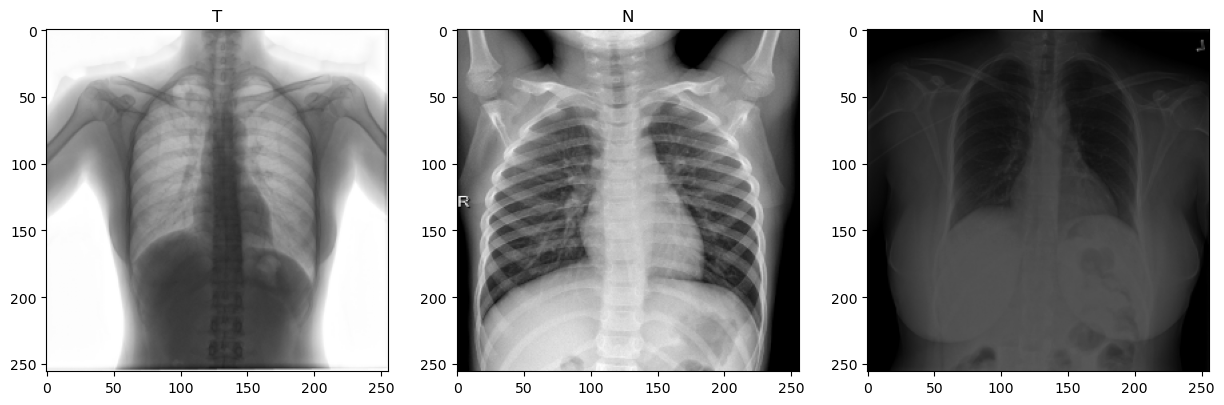

 - Training CNN Model...
Epoch 1/15
  4/151 [..............................] - ETA: 13:39 - loss: 1.2477 - accuracy: 0.3594 - macro_f1: 0.3414

KeyboardInterrupt: 

In [10]:
from sklearn.model_selection import StratifiedKFold

LOSS_FUNCT_TO_USE = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS_TO_TRACK = [ 'accuracy', macro_f1 ]

## TRAINING PARAMS
BATCH_SIZE = 64
EPOCHS = 15

## MODEL PARAMS
CNN_LAYERS = [ 3, 5, 7 ]

## RESULTS
training_results = []

for n_cnn_layers in CNN_LAYERS:
    param_results = []

    skf = StratifiedKFold(n_splits=5)
    for i, (train_idx, valid_idx) in enumerate(skf.split(X_data, Y_data)):
        callback = keras.callbacks.EarlyStopping('val_macro_f1', mode='max', restore_best_weights=True, verbose=1, patience=2)

        print("=" * 100)
        print(f"\t Layers: {n_cnn_layers} || Training for Fold", i+1)
        print("=" * 100)

        # get the ids and build the datasets
        train_ids, valid_ids = X_data[train_idx], X_data[valid_idx]
        train_ds, valid_ds = define_dataset(train_ids, valid_ids)
        
        # visualize samples
        visualize_data_samples( train_ds )
        print("=" * 100)

        # get normalization values and build model
        stats = get_normalization_values( train_ds )
        cnn_model = build_cnn_model( n_cnn_layers, stats=stats, num_classes=3 )

        # batch data
        train_ds = train_ds.batch(BATCH_SIZE)
        valid_ds = valid_ds.batch(BATCH_SIZE)

        # compute the class_weights in the training data
        Y_train = Y_data[train_idx]
        train_weigths = class_weight.compute_class_weight( 'balanced', classes=CLASS_NAMES, y=Y_train )
        train_weigths_dict = dict(enumerate(train_weigths)) 

        # Training ---- Training CNN model
        print( " - Training CNN Model..." )
        cnn_model.compile(optimizer='adam', loss=LOSS_FUNCT_TO_USE, metrics=METRICS_TO_TRACK)
        history = cnn_model.fit(
            train_ds,
            validation_data=valid_ds,
            epochs=EPOCHS,
            class_weight=train_weigths_dict,
            callbacks=[callback]
        )
        plot_model_training_hist(history)
        print("=" * 100)

        # get and store the results
        fold_results = evaluate_model(valid_ds, cnn_model)
        fold_best_epoch = np.argmax( history.history['val_macro_f1'] ) + 1
        fold_results['best_epoch'] = fold_best_epoch

        param_results.append(fold_results)
        del cnn_model, callback

    # calculate the training results
    param_results = pd.DataFrame.from_records(param_results)
    cv_results = param_results.mean(axis=0).to_dict()

    # add the parameters / 
    cv_results['cnn_layers'] = n_cnn_layers
    training_results.append( cv_results )
    
training_results = pd.DataFrame.from_records( training_results )
training_results.to_csv( os.path.join(RESULTS_DIR, 'simple_cnn.csv') )

training_results